# Deep Emulator: a Multi-Layer Perceptron

We use preprocessed data from tunax simulations of the Kato-Phillips case to train a basic neural network. From five channels of input as represented below, it learns to predict the state of the temperature residual column at time t+1 ($\Delta T$).

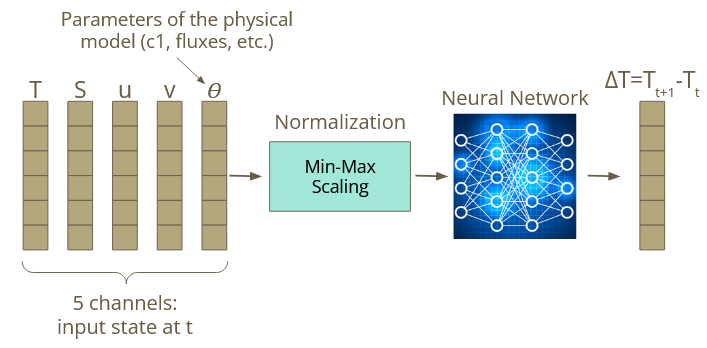

In [17]:
%matplotlib inline
from IPython.display import Image
Image('data_process.png')

The notebook is structured as follows:
1. Imports
2. Data Loading
3. Initialization of the Multi-Layer Perceptron
4. Training
5. Visualization (Loss)

### 1. Imports

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random, vmap
from jax.example_libraries import optimizers
import numpy as np
import matplotlib.pyplot as plt
import pickle

### 2. Data Loading

In [5]:
import numpy as np

In [7]:
train_data = np.load("data/train_data.npy")
train_labels = np.load("data/train_labels.npy")
test_data = np.load("data/test_data.npy")
test_labels = np.load("data/test_labels.npy")

# Convert to jax
train_data = jnp.array(train_data)
train_labels = jnp.array(train_labels)
test_data = jnp.array(test_data)
test_labels = jnp.array(test_labels)

### 3. Initialization of the Multi-Layer Perceptron

In [16]:
def init_mlp_params(layer_sizes, key):
    keys = random.split(key, len(layer_sizes) - 1)
    params = []
    for m, n, k in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weight = random.normal(k, (m, n)) * jnp.sqrt(2.0 / m)
        bias = jnp.zeros(n)
        params.append((weight, bias))
    return params

def mlp(params, x):
    for w, b in params[:-1]:
        x = jnp.tanh(jnp.dot(x, w) + b)
    w_last, b_last = params[-1]
    return jnp.dot(x, w_last) + b_last

# Adapter les entrées pour le MLP
def reshape_data(x):
    # Reshape les données de `(n_sim, 5, depth)` à `(n_sim, 5 * depth)`
    return x.reshape(x.shape[0], -1)

In [12]:
# Initialize MLP parameters
input_size = train_data.shape[1] * train_data.shape[2]
layer_sizes = [input_size, 64, 64, 1]  # 5 -> 64 -> 64 -> 1
key = random.PRNGKey(0)
params = init_mlp_params(layer_sizes, key)

In [13]:
# Loss function
def loss_fn(params, x, y):
    predictions = mlp(params, reshape_data(x))
    return jnp.mean((predictions - y) ** 2) # MSE

# Optimizer
opt_init, opt_update, get_params = optimizers.adam(5e-4)
opt_state = opt_init(params)

# Accelerate loss with jit
loss_fn_jit = jit(loss_fn)

@jit
def update(step, opt_state, x, y):
    params = get_params(opt_state)
    gradients = grad(loss_fn)(params, x, y)
    return opt_update(step, gradients, opt_state)

### 4. Training

In [14]:
num_epochs = 20
batch_size = 64
num_batches = train_data.shape[0] // batch_size

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    perm = random.permutation(key, train_data.shape[0])  # Shuffle indices
    train_data = train_data[perm]
    train_labels = train_labels[perm]

    assert not jnp.isnan(train_data).any(), "NaN in train_data"
    assert not jnp.isnan(train_labels).any(), "NaN in train_labels"

    for i in range(num_batches):
        batch_x = train_data[i * batch_size:(i + 1) * batch_size]
        batch_y = train_labels[i * batch_size:(i + 1) * batch_size]
        opt_state = update(epoch * num_batches + i, opt_state, batch_x, batch_y)

    # Track losses
    params = get_params(opt_state)
    train_loss = loss_fn_jit(params, train_data, train_labels)
    test_loss = loss_fn_jit(params, test_data, test_labels)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Save model parameters in .pth (cf. pytorch)
params = get_params(opt_state)
with open("mlp_model.pth", "wb") as f:
    pickle.dump(params, f)
print("Saved as 'mlp_model.pth'.")

Epoch 0, Train Loss: 0.0094, Test Loss: 0.0087
Epoch 10, Train Loss: 0.0005, Test Loss: 0.0005
Saved as 'mlp_model.pth'.


### 5. Visualization

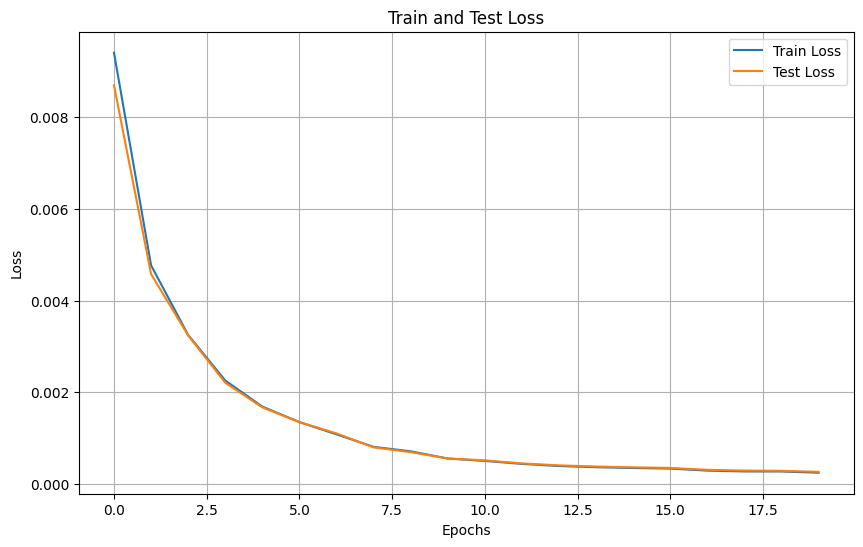

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")  # Save figure
plt.show()

# Load model from .pth file
def load_model(file_path):
    with open(file_path, "rb") as f:
        params = pickle.load(f)
    return params

# Load model
loaded_params = load_model("mlp_model.pth")

# Prediction for test set
test_predictions = vmap(lambda x: mlp(loaded_params, x))(reshape_data(test_data))

In [ ]:
# With Flax

In [18]:
train_data = np.load("data/train_data.npy")
train_labels = np.load("data/train_labels.npy")
test_data = np.load("data/test_data.npy")
test_labels = np.load("data/test_labels.npy")

# Convert to jax
train_data = jnp.array(train_data)
train_labels = jnp.array(train_labels)
test_data = jnp.array(test_data)
test_labels = jnp.array(test_labels)

In [19]:
import os
import jax
import jax.numpy as jnp
import jax.random as random
from flax import linen as nn
from flax.training import train_state
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import optax
import matplotlib.pyplot as plt

checkpoint_dir = os.path.abspath("checkpoints")

# MLP Model Definition with Flax
class MLP(nn.Module):
    hidden_sizes: list

    @nn.compact
    def __call__(self, x):
        x = x.reshape(x.shape[0], -1)  # Reshape to (batch_size, 5 * depth)
        for size in self.hidden_sizes:
            x = nn.Dense(features=size)(x)
            x = nn.tanh(x)
        x = nn.Dense(features=1)(x)  # Output layer
        return x

# Create TrainState to Manage Parameters and Optimizer
def create_train_state(rng, model, learning_rate, input_shape):
    params = model.init(rng, jnp.ones(input_shape))  # Initialize parameters
    tx = optax.adam(learning_rate)  # Optimizer
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Training Step
@jax.jit
def train_step(state, x, y):
    def loss_fn(params):
        predictions = state.apply_fn(params, x)
        loss = jnp.mean((predictions - y) ** 2)  # MSE Loss
        return loss
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Evaluation Step
@jax.jit
def eval_step(state, x, y):
    predictions = state.apply_fn(state.params, x)
    loss = jnp.mean((predictions - y) ** 2)  # MSE Loss
    return loss

# Main Training Loop
def train_and_evaluate(train_data, train_labels, test_data, test_labels, depth, num_epochs, batch_size, learning_rate):
    key = random.PRNGKey(0)
    model = MLP(hidden_sizes=[64, 64])

    # Create TrainState
    input_shape = (batch_size, 5, depth)
    state = create_train_state(key, model, learning_rate, input_shape)

    num_batches = train_data.shape[0] // batch_size
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = random.permutation(key, train_data.shape[0])
        train_data = train_data[perm]
        train_labels = train_labels[perm]

        # Train
        epoch_loss = 0
        for i in range(num_batches):
            batch_x = train_data[i * batch_size:(i + 1) * batch_size]
            batch_y = train_labels[i * batch_size:(i + 1) * batch_size]
            state, loss = train_step(state, batch_x, batch_y)
            epoch_loss += loss

        # Track loss
        epoch_loss /= num_batches
        test_loss = eval_step(state, test_data, test_labels)

        train_losses.append(epoch_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Save the model
    save_checkpoint(checkpoint_dir, target=state.params, step=num_epochs)
    print("Model saved to 'checkpoints/'.")

    # Plot the losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Train and Test Loss")
    plt.show()

    return state

Epoch 1, Train Loss: 0.0097, Test Loss: 0.0015
Epoch 2, Train Loss: 0.0007, Test Loss: 0.0004
Epoch 3, Train Loss: 0.0004, Test Loss: 0.0003
Epoch 4, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 5, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 6, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 7, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 8, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 9, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 10, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 11, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 12, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 13, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 14, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 15, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 16, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 17, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 18, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 19, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 20, Train Loss: 0.0000, Test Loss: 0.0000
Model saved to 'checkpoints/'.


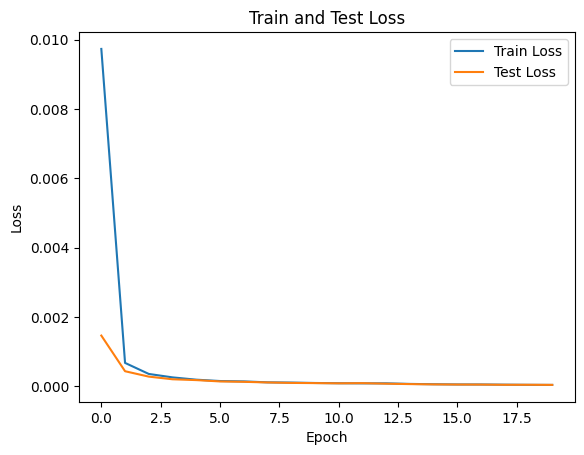

In [20]:
# Example usage:
# Assuming train_data, train_labels, test_data, and test_labels are preprocessed and loaded
depth = train_data.shape[2]  # Assuming input shape (n_sim, 5, depth)
num_epochs = 20
batch_size = 64
learning_rate = 5e-4

state = train_and_evaluate(train_data, train_labels, test_data, 
                           test_labels, depth, num_epochs, 
                           batch_size, learning_rate)

In [ ]:
# To reload the model
restored_params = restore_checkpoint("checkpoints", target=None)
print("Model parameters restored from 'checkpoints/'.")